**<h1 align="center">SIEMENS SALES FORECAST</h1>**

1. What is the objective of the model?

> We are tasked with creating a `monthly sales forecast`model for a subset of products from one Siemens business unit in Germany.

2. What data is available?

>Daily sales for specific product groups; <br>
>Macroeconomic features (indices for energy prices, raw materials, etc...)

3. How will the project be assessed?

> The model will be assessed quantitatively based on RMSE, plus there will be a quanlitative component (presentation and code review)

The stakeholders in this project are the management team in SIEMENS Advanta Consulting -the in-house consultancy for **digital transformation and data-driven solutions**, and the faculty responsible for the course Business Cases with Data Science.


This notebook will follow CRISP-DM (Cross Industry Standard Process for Data Mining) as a systematic approach:
* Business understanding
* Data understanding
* Data preparation
* Modeling
* Evaluation
* Deployment

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configurations
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Business Understanding

## Understand the products for which we will be predicting sales

`Insights:`

There are 14 different products in the dataset. The product with the highest frequency is product #1, with 1179 sales. The total revenue is 2673845300.67 EUR. The top 3 products account for 93.77% of the total revenue.

In [2]:
sales_data = pd.read_csv('../Data/Case2_Sales data.csv', sep=";")

In [3]:
sales_data.sample(10)

,DATE,Mapped_GCK,Sales_EUR
3067,11.06.2019,#16,0
1058,16.07.2021,#8,"50770,64"
4272,11.02.2021,#6,0
9018,09.07.2019,#20,0
131,29.03.2022,#6,"20469,21"
3600,15.07.2021,#3,0
5271,19.08.2021,#11,0
5726,07.01.2019,#5,0
4386,16.12.2019,#11,0
9380,05.05.2021,#6,0


In [4]:
# Verify the data types
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


In [ ]:
sales_data.columns

Index(['DATE', 'Mapped_GCK', 'Sales_EUR'], dtype='object')

### Convert data types

Sales_EUR is a object, and must be converted to numerical

In [5]:
# Then try converting with 'to_numeric'. 
# 'errors="coerce"' will replace anything unparseable with NaN
sales_data['Sales_EUR'] = (
    sales_data['Sales_EUR']
    .replace(',','.', regex=True)        # if commas are being used as decimals
    .replace(r'[^0-9\.\-]', '', regex=True)  # remove any characters that aren’t digits, dot, or minus
    .pipe(pd.to_numeric, errors='coerce')
)

In [42]:
sales_data['Sales_EUR'].dtype

dtype('float64')

DATE is object, and must be converted to datetime

In [44]:
# Convert the DATE column to datetime
sales_data['DATE'] = pd.to_datetime(sales_data['DATE'], format='%d.%m.%Y')

In [47]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        9802 non-null   datetime64[ns]
 1   Mapped_GCK  9802 non-null   object        
 2   Sales_EUR   9795 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 229.9+ KB


### Sales volume

* There are 14 different products in the dataset.
* The product with the highest frequency is product #1, with 1179 sales.


In [8]:
# Check the number of products
sales_data['Mapped_GCK'].nunique()
print(f'There are {sales_data["Mapped_GCK"].nunique()} different products in the dataset.')

There are 14 different products in the dataset.


In [9]:
# Check the products
sales_data['Mapped_GCK'].unique()

array(['#1', '#11', '#6', '#8', '#12', '#16', '#4', '#5', '#3', '#9',
       '#14', '#13', '#20', '#36'], dtype=object)

In [10]:
# Check the distribution of the products by sales volume
sales_data['Mapped_GCK'].value_counts().sort_values(ascending=False)


Mapped_GCK
#1     1179
#3     1017
#5      959
#8      944
#4      877
#12     803
#6      794
#16     765
#11     732
#13     441
#36     434
#9      333
#20     293
#14     231
Name: count, dtype: int64

In [11]:
print(f'The product with the highest frequency is product {sales_data["Mapped_GCK"].value_counts().idxmax()}, with {sales_data["Mapped_GCK"].value_counts().max()} sales.')

The product with the highest frequency is product #1, with 1179 sales.


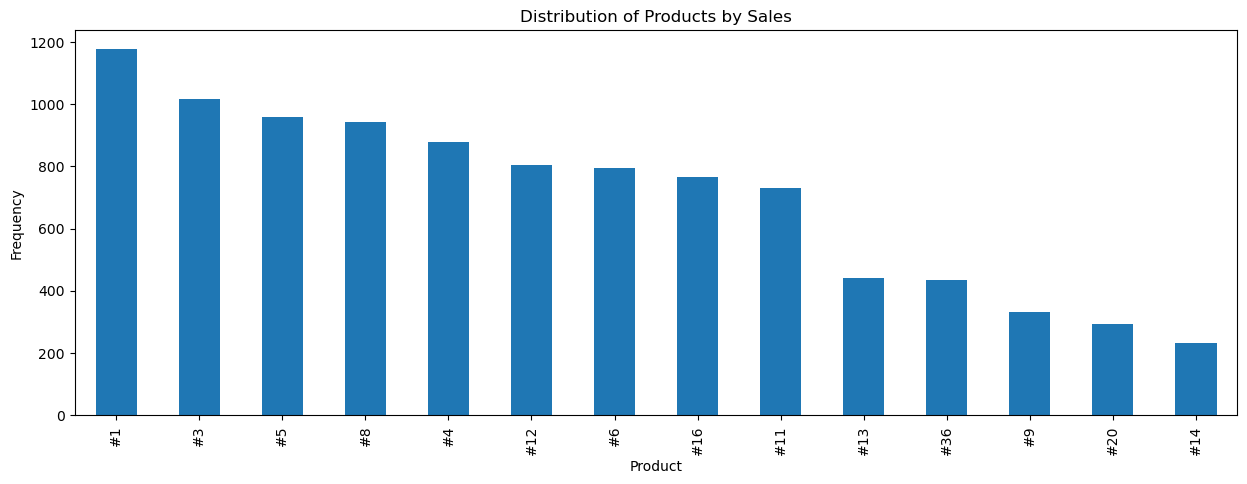

In [12]:
# plot the distribution of the products by sales
plt.figure(figsize=(15, 5))
sales_data['Mapped_GCK'].value_counts().plot(kind='bar')
plt.xlabel('Product')
plt.ylabel('Frequency')
plt.title('Distribution of Products by Sales')
plt.show()

### Sales revenue

* The total revenue is 2673845300.67 EUR.
* The dataset is highly imbalanced in terms of sales, with the top 3 products accounting for 93.77% of the total revenue.


In [14]:
# Check total revenue per product
sales_data.groupby('Mapped_GCK')['Sales_EUR'].sum()

Mapped_GCK
#1     1.544206e+09
#11    6.590131e+07
#12    8.279486e+06
#13    1.009157e+06
#14    4.938221e+05
#16    1.839118e+07
#20    7.832686e+04
#3     5.334435e+08
#36    9.986139e+05
#4     1.562720e+07
#5     4.295952e+08
#6     2.064189e+07
#8     3.487122e+07
#9     3.084465e+05
Name: Sales_EUR, dtype: float64

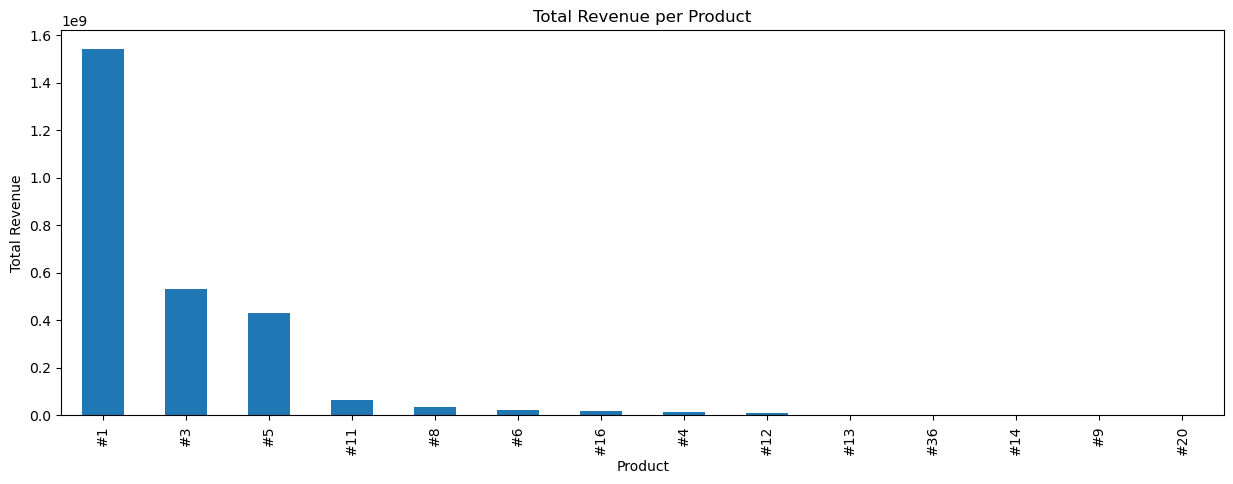

In [15]:
# Make a bar plot of total revenue per product
plt.figure(figsize=(15, 5))
(sales_data.groupby('Mapped_GCK')['Sales_EUR'].sum()
 .sort_values(ascending=False)
 .plot(kind='bar')
)
plt.xlabel('Product')
plt.ylabel('Total Revenue')
plt.title('Total Revenue per Product')
plt.show()

In [16]:
# Verify what is the percetange of the total revenue generated by the top 3 products
top3_revenue = sales_data.groupby('Mapped_GCK')['Sales_EUR'].sum().sort_values(ascending=False).head(3).sum()
total_revenue = sales_data['Sales_EUR'].sum()
top3_revenue_percent = (top3_revenue / total_revenue) * 100
print(f'The total revenue is {total_revenue:.2f} EUR.')
print(f'The top 3 products account for {top3_revenue_percent:.2f}% of the total revenue.')

The total revenue is 2673845300.67 EUR.
The top 3 products account for 93.77% of the total revenue.


### Seasonal effects


#### Volume of sales by month

In [48]:
# Check the sales distribution per month
sales_data['Month'] = sales_data['DATE'].dt.month
sales_data['Month'].value_counts()

Month
3     969
10    932
11    925
1     900
2     872
4     859
12    823
9     740
7     733
6     693
8     690
5     666
Name: count, dtype: int64

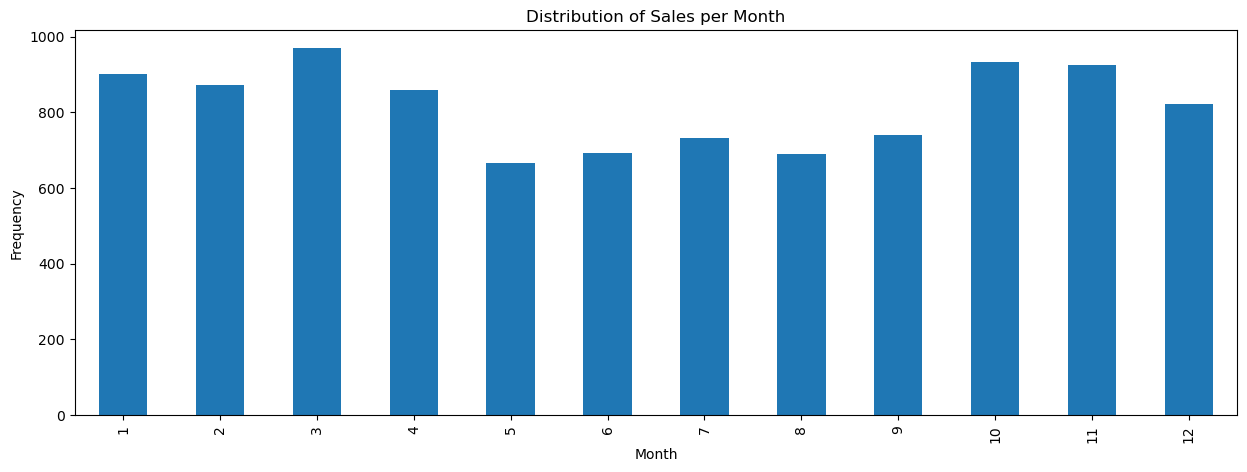

In [49]:
# plot the distribution of the sales per month
plt.figure(figsize=(15, 5))
sales_data['Month'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Distribution of Sales per Month')
plt.show()

## Identify major drivers for demand for the product groups

Macro indicators like energy prices might matter for switchgear products

## Consider seasonal effects
 
Summer/winter patterns, quarterly business cycles, holidays

# Loading the data

In [17]:
# Import xlsx dataset into pandas dataframe
data = pd.read_excel('/Users/diogocarvalho/Documents/GitHub/Case-2--Siemens-Sales-Forecast/Data/Case2_Market data.xlsx', header=[0,1,2])

In [18]:
# Verify how the data looks
data.head()

Unnamed: 0_level_0  \
  Index 2010=100 (if not otherwise noted)   
                                     date   
0                                  2004m2   
1                                  2004m3   
2                                  2004m4   
3                                  2004m5   
4                                  2004m6   

                                     China  \
  Production Index Machinery & Electricals   
                            MAB_ELE_PRO156   
0                                16.940704   
1                                23.711852   
2                                24.435235   
3                                23.708115   
4                                27.009138   

                                           \
  Shipments Index Machinery & Electricals   
                           MAB_ELE_SHP156   
0                               16.940704   
1                               23.711852   
2                               24.435235   
3                               23.708115   
4                               27.009138   

                                    France  \
  Production Index Machinery & Electricals   
                            MAB_ELE_PRO250   
0                               112.091273   
1                               136.327976   
2                               117.791806   
3                               109.002541   
4                               133.785737   

                                           \
  Shipments Index Machinery & Electricals   
                           MAB_ELE_SHP250   
0                               83.458866   
1                              106.168192   
2                               92.007646   
3                               85.696486   
4                              106.641482   

                                   Germany  \
  Production Index Machinery & Electricals   
                            MAB_ELE_PRO276   
0                                82.623037   
1                               100.556582   
2                                89.653203   
3                                86.880571   
4                                99.010814   

                                           \
  Shipments Index Machinery & Electricals   
                           MAB_ELE_SHP276   
0                               79.452532   
1                               97.012918   
2                               84.932358   
3                               82.372794   
4                               95.108740   

                                     Italy  \
  Production Index Machinery & Electricals   
                            MAB_ELE_PRO380   
0                               124.289603   
1                               143.411662   
2                               129.083828   
3                               135.590391   
4                               136.424935   

                                           \
  Shipments Index Machinery & Electricals   
                           MAB_ELE_SHP380   
0                               86.560493   
1                              106.344544   
2                               95.579673   
3                              100.087039   
4                              110.889719   

                                     Japan  \
  Production Index Machinery & Electricals   
                            MAB_ELE_PRO392   
0                               109.334010   
1                               140.884616   
2                               105.853579   
3                               101.864777   
4                               120.332920   

                                           \
  Shipments Index Machinery & Electricals   
                           MAB_ELE_SHP392   
0                              110.495272   
1                              144.686166   
2                              102.655769   
3                              100.305285   
4                              119.616380   

            

In [19]:
# Check the shape of the data
data.shape

(219, 48)

In [20]:
# Check the columns of the data
data.columns

MultiIndex([('Unnamed: 0_level_0', ...),
            (             'China', ...),
            (             'China', ...),
            (            'France', ...),
            (            'France', ...),
            (           'Germany', ...),
            (           'Germany', ...),
            (             'Italy', ...),
            (             'Italy', ...),
            (             'Japan', ...),
            (             'Japan', ...),
            (       'Switzerland', ...),
            (       'Switzerland', ...),
            (    'United Kingdom', ...),
            (    'United Kingdom', ...),
            (     'United States', ...),
            (     'United States', ...),
            (            'Europe', ...),
            (            'Europe', ...),
            (            'Europe', ...),
            (            'Europe', ...),
            (            'Europe', ...),
            (            'Europe', ...),
            (            'Europe', ...),
            (   

In [21]:
# Join the header levels
data.columns = [
    '_'.join([str(level) for level in col_tuple]).strip()
    for col_tuple in data.columns
]


In [22]:
data.head()

,Unnamed: 0_level_0_Index 2010=100 (if not otherwise noted)_date,China_Production Index Machinery & Electricals_MAB_ELE_PRO156,China_Shipments Index Machinery & Electricals_MAB_ELE_SHP156,France_Production Index Machinery & Electricals_MAB_ELE_PRO250,France_Shipments Index Machinery & Electricals_MAB_ELE_SHP250,Germany_Production Index Machinery & Electricals_MAB_ELE_PRO276,Germany_Shipments Index Machinery & Electricals_MAB_ELE_SHP276,Italy_Production Index Machinery & Electricals_MAB_ELE_PRO380,Italy_Shipments Index Machinery & Electricals_MAB_ELE_SHP380,Japan_Production Index Machinery & Electricals_MAB_ELE_PRO392,Japan_Shipments Index Machinery & Electricals_MAB_ELE_SHP392,Switzerland_Production Index Machinery & Electricals_MAB_ELE_PRO756,Switzerland_Shipments Index Machinery & Electricals_MAB_ELE_SHP756,United Kingdom_Production Index Machinery & Electricals_MAB_ELE_PRO826,United Kingdom_Shipments Index Machinery & Electricals_MAB_ELE_SHP826,United States_Production Index Machinery & Electricals_MAB_ELE_PRO840,United States_Shipments Index Machinery & Electricals_MAB_ELE_SHP840,Europe_Production Index Machinery & Electricals_MAB_ELE_PRO1100,Europe_Shipments Index Machinery & Electricals_MAB_ELE_SHP1100,Europe_World: Price of Base Metals_RohiBASEMET1000_org,Europe_World: Price of Energy_RohiENERGY1000_org,Europe_World: Price of Metals & Minerals_RohiMETMIN1000_org,Europe_World: Price of Natural gas index_RohiNATGAS1000_org,"Europe_World: Price of Crude oil, average_RohCRUDE_PETRO1000_org",Europe_World: Price of Copper_RohCOPPER1000_org,Europe_United States: EUR in LCU_WKLWEUR840_org,Producer Prices_United States: Electrical equipment_PRI27840_org,Producer Prices_United Kingdom: Electrical equipment_PRI27826_org,Producer Prices_Italy: Electrical equipment_PRI27380_org,Producer Prices_France: Electrical equipment_PRI27250_org,Producer Prices_Germany: Electrical equipment_PRI27276_org,Producer Prices_China: Electrical equipment_PRI27156_org,production index_United States: Machinery and equipment n.e.c._PRO28840_org,production index_World: Machinery and equipment n.e.c._PRO281000_org,production index_Switzerland: Machinery and equipment n.e.c._PRO28756_org,production index_United Kingdom: Machinery and equipment n.e.c._PRO28826_org,production index_Italy: Machinery and equipment n.e.c._PRO28380_org,production index_Japan: Machinery and equipment n.e.c._PRO28392_org,production index_France: Machinery and equipment n.e.c._PRO28250_org,production index_Germany: Machinery and equipment n.e.c._PRO28276_org,production index_United States: Electrical equipment_PRO27840_org,production index_World: Electrical equipment_PRO271000_org,production index_Switzerland: Electrical equipment_PRO27756_org,production index_United Kingdom: Electrical equipment_PRO27826_org,production index_Italy: Electrical equipment_PRO27380_org,production index_Japan: Electrical equipment_PRO27392_org,production index_France: Electrical equipment_PRO27250_org,production index_Germany: Electrical equipment_PRO27276_org
0,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.334010,110.495272,91.221862,89.987275,111.353812,73.601265,107.601400,79.240230,97.122911,80.098530,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.100000,106.191977,116.790276,110.890034,118.274109,80.829010,117.723991,NaN,81.100000,120.706516,141.510864,106.161262,102.077057,85.913200
1,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.627480,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.309550,152.880234,140.288741,117.225685,97.670815
2,2004m

In [23]:
data.columns

Index(['Unnamed: 0_level_0_Index 2010=100 (if not otherwise noted)_date',
       'China_Production Index Machinery & Electricals_MAB_ELE_PRO156',
       'China_Shipments Index Machinery & Electricals_MAB_ELE_SHP156',
       'France_Production Index Machinery & Electricals_MAB_ELE_PRO250',
       'France_Shipments Index Machinery & Electricals_MAB_ELE_SHP250',
       'Germany_Production Index Machinery & Electricals_MAB_ELE_PRO276',
       'Germany_Shipments Index Machinery & Electricals_MAB_ELE_SHP276',
       'Italy_Production Index Machinery & Electricals_MAB_ELE_PRO380',
       'Italy_Shipments Index Machinery & Electricals_MAB_ELE_SHP380',
       'Japan_Production Index Machinery & Electricals_MAB_ELE_PRO392',
       'Japan_Shipments Index Machinery & Electricals_MAB_ELE_SHP392',
       'Switzerland_Production Index Machinery & Electricals_MAB_ELE_PRO756',
       'Switzerland_Shipments Index Machinery & Electricals_MAB_ELE_SHP756',
       'United Kingdom_Production Index Machinery 

In [24]:
# change first columne name to "Date"
data.rename(columns={'Unnamed: 0_level_0_Index 2010=100 (if not otherwise noted)_date': 'Date'}, inplace=True)

In [25]:
# Verify changes
data.head()

,Date,China_Production Index Machinery & Electricals_MAB_ELE_PRO156,China_Shipments Index Machinery & Electricals_MAB_ELE_SHP156,France_Production Index Machinery & Electricals_MAB_ELE_PRO250,France_Shipments Index Machinery & Electricals_MAB_ELE_SHP250,Germany_Production Index Machinery & Electricals_MAB_ELE_PRO276,Germany_Shipments Index Machinery & Electricals_MAB_ELE_SHP276,Italy_Production Index Machinery & Electricals_MAB_ELE_PRO380,Italy_Shipments Index Machinery & Electricals_MAB_ELE_SHP380,Japan_Production Index Machinery & Electricals_MAB_ELE_PRO392,Japan_Shipments Index Machinery & Electricals_MAB_ELE_SHP392,Switzerland_Production Index Machinery & Electricals_MAB_ELE_PRO756,Switzerland_Shipments Index Machinery & Electricals_MAB_ELE_SHP756,United Kingdom_Production Index Machinery & Electricals_MAB_ELE_PRO826,United Kingdom_Shipments Index Machinery & Electricals_MAB_ELE_SHP826,United States_Production Index Machinery & Electricals_MAB_ELE_PRO840,United States_Shipments Index Machinery & Electricals_MAB_ELE_SHP840,Europe_Production Index Machinery & Electricals_MAB_ELE_PRO1100,Europe_Shipments Index Machinery & Electricals_MAB_ELE_SHP1100,Europe_World: Price of Base Metals_RohiBASEMET1000_org,Europe_World: Price of Energy_RohiENERGY1000_org,Europe_World: Price of Metals & Minerals_RohiMETMIN1000_org,Europe_World: Price of Natural gas index_RohiNATGAS1000_org,"Europe_World: Price of Crude oil, average_RohCRUDE_PETRO1000_org",Europe_World: Price of Copper_RohCOPPER1000_org,Europe_United States: EUR in LCU_WKLWEUR840_org,Producer Prices_United States: Electrical equipment_PRI27840_org,Producer Prices_United Kingdom: Electrical equipment_PRI27826_org,Producer Prices_Italy: Electrical equipment_PRI27380_org,Producer Prices_France: Electrical equipment_PRI27250_org,Producer Prices_Germany: Electrical equipment_PRI27276_org,Producer Prices_China: Electrical equipment_PRI27156_org,production index_United States: Machinery and equipment n.e.c._PRO28840_org,production index_World: Machinery and equipment n.e.c._PRO281000_org,production index_Switzerland: Machinery and equipment n.e.c._PRO28756_org,production index_United Kingdom: Machinery and equipment n.e.c._PRO28826_org,production index_Italy: Machinery and equipment n.e.c._PRO28380_org,production index_Japan: Machinery and equipment n.e.c._PRO28392_org,production index_France: Machinery and equipment n.e.c._PRO28250_org,production index_Germany: Machinery and equipment n.e.c._PRO28276_org,production index_United States: Electrical equipment_PRO27840_org,production index_World: Electrical equipment_PRO271000_org,production index_Switzerland: Electrical equipment_PRO27756_org,production index_United Kingdom: Electrical equipment_PRO27826_org,production index_Italy: Electrical equipment_PRO27380_org,production index_Japan: Electrical equipment_PRO27392_org,production index_France: Electrical equipment_PRO27250_org,production index_Germany: Electrical equipment_PRO27276_org
0,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.334010,110.495272,91.221862,89.987275,111.353812,73.601265,107.601400,79.240230,97.122911,80.098530,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.100000,106.191977,116.790276,110.890034,118.274109,80.829010,117.723991,NaN,81.100000,120.706516,141.510864,106.161262,102.077057,85.913200
1,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.627480,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.309550,152.880234,140.288741,117.225685,97.670815
2,2004m4,24.435235,24.435235,117.791806,92.007646,89.653203,84.932

In [26]:
# Make Date the index
data.set_index('Date', inplace=True)

In [27]:
# Verify changes
data.head()

,China_Production Index Machinery & Electricals_MAB_ELE_PRO156,China_Shipments Index Machinery & Electricals_MAB_ELE_SHP156,France_Production Index Machinery & Electricals_MAB_ELE_PRO250,France_Shipments Index Machinery & Electricals_MAB_ELE_SHP250,Germany_Production Index Machinery & Electricals_MAB_ELE_PRO276,Germany_Shipments Index Machinery & Electricals_MAB_ELE_SHP276,Italy_Production Index Machinery & Electricals_MAB_ELE_PRO380,Italy_Shipments Index Machinery & Electricals_MAB_ELE_SHP380,Japan_Production Index Machinery & Electricals_MAB_ELE_PRO392,Japan_Shipments Index Machinery & Electricals_MAB_ELE_SHP392,Switzerland_Production Index Machinery & Electricals_MAB_ELE_PRO756,Switzerland_Shipments Index Machinery & Electricals_MAB_ELE_SHP756,United Kingdom_Production Index Machinery & Electricals_MAB_ELE_PRO826,United Kingdom_Shipments Index Machinery & Electricals_MAB_ELE_SHP826,United States_Production Index Machinery & Electricals_MAB_ELE_PRO840,United States_Shipments Index Machinery & Electricals_MAB_ELE_SHP840,Europe_Production Index Machinery & Electricals_MAB_ELE_PRO1100,Europe_Shipments Index Machinery & Electricals_MAB_ELE_SHP1100,Europe_World: Price of Base Metals_RohiBASEMET1000_org,Europe_World: Price of Energy_RohiENERGY1000_org,Europe_World: Price of Metals & Minerals_RohiMETMIN1000_org,Europe_World: Price of Natural gas index_RohiNATGAS1000_org,"Europe_World: Price of Crude oil, average_RohCRUDE_PETRO1000_org",Europe_World: Price of Copper_RohCOPPER1000_org,Europe_United States: EUR in LCU_WKLWEUR840_org,Producer Prices_United States: Electrical equipment_PRI27840_org,Producer Prices_United Kingdom: Electrical equipment_PRI27826_org,Producer Prices_Italy: Electrical equipment_PRI27380_org,Producer Prices_France: Electrical equipment_PRI27250_org,Producer Prices_Germany: Electrical equipment_PRI27276_org,Producer Prices_China: Electrical equipment_PRI27156_org,production index_United States: Machinery and equipment n.e.c._PRO28840_org,production index_World: Machinery and equipment n.e.c._PRO281000_org,production index_Switzerland: Machinery and equipment n.e.c._PRO28756_org,production index_United Kingdom: Machinery and equipment n.e.c._PRO28826_org,production index_Italy: Machinery and equipment n.e.c._PRO28380_org,production index_Japan: Machinery and equipment n.e.c._PRO28392_org,production index_France: Machinery and equipment n.e.c._PRO28250_org,production index_Germany: Machinery and equipment n.e.c._PRO28276_org,production index_United States: Electrical equipment_PRO27840_org,production index_World: Electrical equipment_PRO271000_org,production index_Switzerland: Electrical equipment_PRO27756_org,production index_United Kingdom: Electrical equipment_PRO27826_org,production index_Italy: Electrical equipment_PRO27380_org,production index_Japan: Electrical equipment_PRO27392_org,production index_France: Electrical equipment_PRO27250_org,production index_Germany: Electrical equipment_PRO27276_org
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.334010,110.495272,91.221862,89.987275,111.353812,73.601265,107.601400,79.240230,97.122911,80.098530,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.100000,106.191977,116.790276,110.890034,118.274109,80.829010,117.723991,NaN,81.100000,120.706516,141.510864,106.161262,102.077057,85.913200
2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.627480,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.309550,152.880234,140.288741,117.225685,97.670815
2004m4,24.435235,24.435

Columns from index 0-18 correspond to sales data (or costs?) <br>
Columns from index 18-24 correspond to price of materials, so keep them in separate dataframe <br>
Columns from index 25-30 corresponde to producer prices <br>
Columns from index 30 onwards correspond to production index

In [28]:
# what is the index of the column 'Europe_World: Price of Base Metals_RohiBASEMET1000_org'
data.columns.get_loc('Producer Prices_China: Electrical equipment_PRI27156_org')

30

In [29]:

data.columns

Index(['China_Production Index Machinery & Electricals_MAB_ELE_PRO156',
       'China_Shipments Index Machinery & Electricals_MAB_ELE_SHP156',
       'France_Production Index Machinery & Electricals_MAB_ELE_PRO250',
       'France_Shipments Index Machinery & Electricals_MAB_ELE_SHP250',
       'Germany_Production Index Machinery & Electricals_MAB_ELE_PRO276',
       'Germany_Shipments Index Machinery & Electricals_MAB_ELE_SHP276',
       'Italy_Production Index Machinery & Electricals_MAB_ELE_PRO380',
       'Italy_Shipments Index Machinery & Electricals_MAB_ELE_SHP380',
       'Japan_Production Index Machinery & Electricals_MAB_ELE_PRO392',
       'Japan_Shipments Index Machinery & Electricals_MAB_ELE_SHP392',
       'Switzerland_Production Index Machinery & Electricals_MAB_ELE_PRO756',
       'Switzerland_Shipments Index Machinery & Electricals_MAB_ELE_SHP756',
       'United Kingdom_Production Index Machinery & Electricals_MAB_ELE_PRO826',
       'United Kingdom_Shipments Index Mach

## sales dataframe

In [30]:
# Slice dataframe and keep the first 20 columns
sales = data.iloc[:, :18]

In [31]:
sales.shape

(219, 18)

In [32]:
sales.columns

Index(['China_Production Index Machinery & Electricals_MAB_ELE_PRO156',
       'China_Shipments Index Machinery & Electricals_MAB_ELE_SHP156',
       'France_Production Index Machinery & Electricals_MAB_ELE_PRO250',
       'France_Shipments Index Machinery & Electricals_MAB_ELE_SHP250',
       'Germany_Production Index Machinery & Electricals_MAB_ELE_PRO276',
       'Germany_Shipments Index Machinery & Electricals_MAB_ELE_SHP276',
       'Italy_Production Index Machinery & Electricals_MAB_ELE_PRO380',
       'Italy_Shipments Index Machinery & Electricals_MAB_ELE_SHP380',
       'Japan_Production Index Machinery & Electricals_MAB_ELE_PRO392',
       'Japan_Shipments Index Machinery & Electricals_MAB_ELE_SHP392',
       'Switzerland_Production Index Machinery & Electricals_MAB_ELE_PRO756',
       'Switzerland_Shipments Index Machinery & Electricals_MAB_ELE_SHP756',
       'United Kingdom_Production Index Machinery & Electricals_MAB_ELE_PRO826',
       'United Kingdom_Shipments Index Mach

## materials_price dataframe

In [33]:
# Slice the dataframe and keep columns 18 to 24
materials_price = data.iloc[:, 18:25]

In [34]:
materials_price.columns

Index(['Europe_World: Price of Base Metals_RohiBASEMET1000_org',
       'Europe_World: Price of Energy_RohiENERGY1000_org',
       'Europe_World: Price of Metals  & Minerals_RohiMETMIN1000_org',
       'Europe_World: Price of Natural gas index_RohiNATGAS1000_org',
       'Europe_World: Price of Crude oil, average_RohCRUDE_PETRO1000_org',
       'Europe_World: Price of Copper_RohCOPPER1000_org',
       'Europe_United States: EUR in LCU_WKLWEUR840_org'],
      dtype='object')

## producer_price dataframe

In [35]:
# Slice the dataframe and keep columns from 25 to 30
producer_price = data.iloc[:, 25:31]

In [36]:
producer_price.columns

Index(['Producer Prices_United States: Electrical equipment_PRI27840_org',
       'Producer Prices_United Kingdom: Electrical equipment_PRI27826_org',
       'Producer Prices_Italy: Electrical equipment_PRI27380_org',
       'Producer Prices_France: Electrical equipment_PRI27250_org',
       'Producer Prices_Germany: Electrical equipment_PRI27276_org',
       'Producer Prices_China: Electrical equipment_PRI27156_org'],
      dtype='object')

## production_index dataframe

In [37]:
# Slice the dataframe and keep columns from 31 to the end
production_index = data.iloc[:, 31:]

In [38]:
production_index.columns

Index(['production index_United States: Machinery and equipment n.e.c._PRO28840_org',
       'production index_World: Machinery and equipment n.e.c._PRO281000_org',
       'production index_Switzerland: Machinery and equipment n.e.c._PRO28756_org',
       'production index_United Kingdom: Machinery and equipment n.e.c._PRO28826_org',
       'production index_Italy: Machinery and equipment n.e.c._PRO28380_org',
       'production index_Japan: Machinery and equipment n.e.c._PRO28392_org',
       'production index_France: Machinery and equipment n.e.c._PRO28250_org',
       'production index_Germany: Machinery and equipment n.e.c._PRO28276_org',
       'production index_United States: Electrical equipment_PRO27840_org',
       'production index_World: Electrical equipment_PRO271000_org',
       'production index_Switzerland: Electrical equipment_PRO27756_org',
       'production index_United Kingdom: Electrical equipment_PRO27826_org',
       'production index_Italy: Electrical equipment_

# EDA

In [39]:
sales.columns

Index(['China_Production Index Machinery & Electricals_MAB_ELE_PRO156',
       'China_Shipments Index Machinery & Electricals_MAB_ELE_SHP156',
       'France_Production Index Machinery & Electricals_MAB_ELE_PRO250',
       'France_Shipments Index Machinery & Electricals_MAB_ELE_SHP250',
       'Germany_Production Index Machinery & Electricals_MAB_ELE_PRO276',
       'Germany_Shipments Index Machinery & Electricals_MAB_ELE_SHP276',
       'Italy_Production Index Machinery & Electricals_MAB_ELE_PRO380',
       'Italy_Shipments Index Machinery & Electricals_MAB_ELE_SHP380',
       'Japan_Production Index Machinery & Electricals_MAB_ELE_PRO392',
       'Japan_Shipments Index Machinery & Electricals_MAB_ELE_SHP392',
       'Switzerland_Production Index Machinery & Electricals_MAB_ELE_PRO756',
       'Switzerland_Shipments Index Machinery & Electricals_MAB_ELE_SHP756',
       'United Kingdom_Production Index Machinery & Electricals_MAB_ELE_PRO826',
       'United Kingdom_Shipments Index Mach

In [40]:
sales.head()

,China_Production Index Machinery & Electricals_MAB_ELE_PRO156,China_Shipments Index Machinery & Electricals_MAB_ELE_SHP156,France_Production Index Machinery & Electricals_MAB_ELE_PRO250,France_Shipments Index Machinery & Electricals_MAB_ELE_SHP250,Germany_Production Index Machinery & Electricals_MAB_ELE_PRO276,Germany_Shipments Index Machinery & Electricals_MAB_ELE_SHP276,Italy_Production Index Machinery & Electricals_MAB_ELE_PRO380,Italy_Shipments Index Machinery & Electricals_MAB_ELE_SHP380,Japan_Production Index Machinery & Electricals_MAB_ELE_PRO392,Japan_Shipments Index Machinery & Electricals_MAB_ELE_SHP392,Switzerland_Production Index Machinery & Electricals_MAB_ELE_PRO756,Switzerland_Shipments Index Machinery & Electricals_MAB_ELE_SHP756,United Kingdom_Production Index Machinery & Electricals_MAB_ELE_PRO826,United Kingdom_Shipments Index Machinery & Electricals_MAB_ELE_SHP826,United States_Production Index Machinery & Electricals_MAB_ELE_PRO840,United States_Shipments Index Machinery & Electricals_MAB_ELE_SHP840,Europe_Production Index Machinery & Electricals_MAB_ELE_PRO1100,Europe_Shipments Index Machinery & Electricals_MAB_ELE_SHP1100
Date,,,,,,,,,,,,,,,,,,
2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.334010,110.495272,91.221862,89.987275,111.353812,73.601265,107.601400,79.240230,97.122911,80.098530
2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929
2004m4,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,85.622508,79.740802,108.732297,73.026027,108.166564,89.774031,101.715199,85.167236
2004m5,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,85.378729,79.598021,110.645200,74.591883,108.425887,87.463813,101.275727,84.485767
2004m6,27.009138,27.009138,133.785737,106.641482,99.010814,95.108740,136.424935,110.889719,120.332920,119.616380,85.134950,79.455239,122.020960,82.343346,110.569933,97.364496,112.057197,96.963294
